In [73]:
import numpy as np
import sympy as sp
from sympy import zeros,Matrix
import matplotlib.pyplot as plt
import sys
from scipy.integrate import quad
from scipy.special import eval_legendre,eval_chebyt
from tqdm import tqdm
sys.setrecursionlimit(20000)

In [74]:
def l(i):
    y = sp.Symbol('y')
    result = 1
    for k in range(n):
        if k != i:
            result = result*(y - T[i])/(T[i]-T[k])
    return result

In [75]:
def double_interp_series(matrix_A,pos):
    global taylor_series
    n_taylor_x = (K* l(pos[1])).subs(x,T[pos[0]])
    n_taylor_x_numpy = sp.lambdify(y,n_taylor_x,'numpy')
    n_result,_ = quad(n_taylor_x_numpy,begin,end)
    matrix_A[pos[0],pos[1]] = n_result
    return matrix_A

In [76]:
def construct_A(n):
    matrix_A = zeros(n)
    pos = []
    for p in range(0, n):
        for q in range(0, n):
            pos.append([p,q])
    for item in tqdm(pos):
        matrix_A = double_interp_series(matrix_A,item)
    Lambda_diag = Lambda*np.matrix(np.diag(np.ones(n)))
    return Lambda_diag - matrix_A

## 主函数
本程序通过插值法构造退化核，插值点考虑legendre、hebyshev、等距插值，进而求解第二类Fredholm方程。
$$\lambda f(x) - \int_a^{b} k(x,y)f(y) dy = g(x)$$

In [77]:
x = sp.Symbol('x')   # 定义符号变量
y = sp.Symbol('y')

In [78]:
# 定义常量，取决于问题求解
Lambda = 1   
K = sp.exp(x*y)
begin = 0
end = 1
f_origin = 1+0*x
# 定义系统变量，可以进行修改
n = 30  # 插值点数
#type = 'legendre'   # legendre插值
#type = 'equal_dist'   # 等距插值
type = 'chebyshev'   # chebyshev插值
degree = 30  # 多项式最高次项次数
# 以下和作图有关
tol = 0  # 图片向(begin,end)两侧拉伸的距离

In [79]:
g = Lambda*f_origin-(K*f_origin.subs(x,y)).integrate((y,begin,end))
print(f"calculate g")
g

calculate g


1 - Piecewise((exp(x)/x - 1/x, (x > -oo) & (x < oo) & Ne(x, 0)), (1, True))

In [80]:
X = np.linspace(begin,end,n)
if type == 'legendre':
    T = eval_legendre(degree,X)
elif type == 'chebyshev':   
    T = eval_chebyt(degree,X)
elif type == 'equal_dist':
    T = X

In [81]:
# 计算矩阵A
A_n = construct_A(n)

100%|██████████| 900/900 [00:53<00:00, 16.88it/s]


In [82]:
# 计算得到 c
y_ = sp.zeros(n,1)
for i in tqdm(range(n)):
    g_mod = (g ).subs('y','x')
    g_mod_numpy = sp.lambdify(x,g_mod,'numpy')
    result,_ = quad(g_mod_numpy,begin,end)
    y_[i, 0] = result
A_n_acce = np.matrix(A_n).astype(np.float64)
A_n_acce_inv = A_n_acce**(-1)
A_n_inv = Matrix(A_n_acce_inv)
c = A_n_inv*y_

100%|██████████| 30/30 [00:00<00:00, 167.69it/s]


In [83]:
result = 0
for i in range(n):
    result = result + l(i)*c[i,0]
f_result = (1/Lambda*(result+g)).subs('y','x')

In [84]:
# 得出计算结果 f(x) ，并画图
disp_val = []
x_begin = begin - tol
x_end = end + tol
x_list = np.arange(x_begin,x_end,(x_end-x_begin)/100)
for i in tqdm(range(len(x_list))):
    disp_val.append(f_result.evalf(subs={'x':x_list[i]})) 

100%|██████████| 100/100 [00:09<00:00, 10.09it/s]


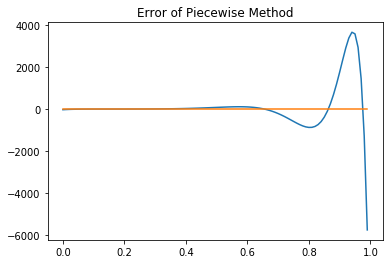

In [85]:
plt.plot(x_list,np.array(disp_val)-1)
plt.plot(x_list,[f_origin.evalf(subs={x,i}) for i in x_list])
plt.title('Error of Piecewise Method')
plt.show()